In [1]:
# Импортируем нужные библиотеки
import os
from tqdm.autonotebook import tqdm, trange
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import pandas as pd
import seaborn as sns

/tmp/ipykernel_321681/2411213856.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Выбираем, где будем тренироать модель, на GPU или CPU
use_gpu = torch.cuda.is_available()

if not use_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Выбираем размер батча (я решил выбрать 25, так как чем больше размер батча, тем быстрее обучается модель, а итоговый результат меня устроил)

In [3]:
batch_size=25

In [4]:
# Трансформируем данные
data_transforms = {
    'train/simpsons_dataset': transforms.Compose([
        # Преобразуем картинки к размеру 224 на 224 пикселя
        transforms.RandomResizedCrop(224),
        # Пример аугментации - случайный поворот по 
        # горизонтальной оси
        transforms.RandomHorizontalFlip(),
        # Преобразование картинки в тензор
        transforms.ToTensor(),
        # Нормализация тензоров по параметрам, указанным в 
        # семинаре из модуля 22
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'testset': transforms.Compose([
        # Преобразуем картинки к размеру 224 на 224 пикселя
        transforms.Resize(224),
        # Центрирование изображения
        transforms.CenterCrop(244),
        # Преобразование картинки в тензор
        transforms.ToTensor(),
        # Нормализация тензоров по параметрам, указанным в 
        # семинаре из модуля 22
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Получение директории, в которой хранятся нужные данные и 
# отдельные данные
data_dir = './data/journey-springfield'
paths = ['train/simpsons_dataset', 'testset']

# Загрузка упорядоченных тренировочных данных по типу 
# root/label/image.png
train_dataset = datasets.ImageFolder(os.path.join(data_dir, paths[0]), data_transforms[paths[0]])
# Разделение выборки на тренировочную и валидационную (точнее 
# получение случайных индексов, по которым затем пойдёт разделение).
# Отношение тренировочной и валидационной части - 3 к 1
train_indices, validation_indices = train_test_split(list(range(len(train_dataset))), train_size = 0.75)
train_dataloader = {
    # Создание даталоадера с преобразованием из data_transforms
    # по ключу 'train/simpsons_dataset' с перемешиванием данных,
    # размером батча в 25, с использованием 2 потоков для расчётов
    # и тренировочных индексов, полученных ранее
    'train': torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(train_dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=2),
    # Создание даталоадера с преобразованием из data_transforms
    # по ключу 'testset' без перемешивания данных, размером батча
    # в 25, с использованием 2 потоков для расчётов
    # и валидационных индексов, полученных ранее
    'val': torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(train_dataset, validation_indices), batch_size=batch_size, shuffle=False, num_workers=2),
}

# Загрузка упорядоченных тестовых данных по типу 
# root/label/image.png
test_dataset = datasets.ImageFolder(os.path.join(data_dir, paths[1]), data_transforms[paths[1]])
# Создание даталоадера с преобразованием из data_transforms
# по ключу 'testset' без перемешивания данных, размером батча
# в 25 и с использованием 2 потоков
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
# Получение размера датасетов
dataset_sizes = {'train': len(train_dataloader['train'].dataset),
                 'val': len(train_dataloader['val'].dataset)}
# Получение имён классов
class_names = train_dataset.classes
# Получение количества итоговых классов
amount = len(class_names)

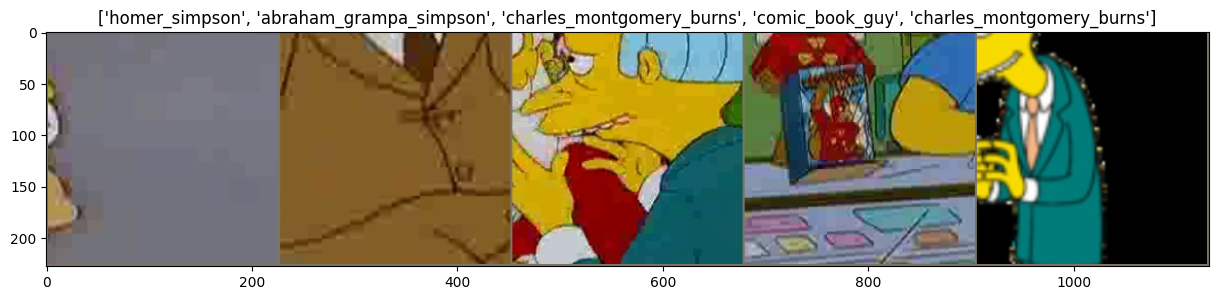

In [6]:
# Функция для вывода некоторых изображений с метками (взята из 
# семинара из модуля 22)
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(train_dataloader['train']))
# Оставим только 5 картинок (25 - многовато)
inputs, classes = inputs[0:5], classes[0:5]

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)
# Вызов функции для отрисовки
imshow(out, title=[class_names[x] for x in classes])

In [7]:
# Функция для тренировки модели на тренировчных данных и 
# оценивания модели с улучшением качества модели по метрике 
# accuracy (взята из семинара из модуля 22)
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    losses = {'train': [], 'val': []}
    pbar = trange(num_epochs, desc="Epoch:")
    for epoch in pbar:
        # Каждая эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Итерируемся по батчам
            for data in tqdm(train_dataloader[phase], leave=False, desc=f"{phase} iter:"):
                # Получаем картинки и метки
                inputs, labels = data
                # Оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # Инициализируем градиенты параметров (если 
                # текущая фаза тренировочная)
                if phase=='train':
                    optimizer.zero_grad()

                # Получаем вероятности предсказаний классов (если
                # текущая фаза оценочная)
                if phase == 'val':
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # Алгоритм обратного распространения ошибки + 
                # оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Подсчитываем статистику
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # Если достиглось лучшее качество, то запомним веса 
            # модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [8]:
# Функция оценивания модели
def predict(model):
    # Переключаем модель в режим оценивания
    model.eval()
    # Вектор предсказания (изначально пустой, позже сюда будут 
    # добавляться классы, в которых модель больше всего уверена
    # для каждой эпохи)
    predictions = torch.Tensor([])
    # Не пересчитываем градиенты
    with torch.no_grad():
        # Проходимся по тестовому датасетц
        for data in test_dataloader:
            inputs, labels = data
            # Переносим вычисления на GPU, если возможно
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
            # Получаем ответы модели
            output = model(inputs).cpu()
            # Выделяем классы, в которых модель больше всего 
            # уверена
            _, local_predictions = torch.max(output, 1)
            # Добавляем такие классы в вектор предсказаний
            predictions = torch.cat([predictions, local_predictions], -1)

        # Возвращаем предсказания
        return predictions

In [9]:
# Устанавливаем модуль efficient_torch
!pip install efficientnet_pytorch

Я решил использовать модель efficientnet-b2. По опытам она 
оказалась оптимальной с точки зрения времени обучения и 
полученных результатов (например одна эпоха обучения модели 
efficientnet-b6 при размере батча в 5 на GPU(!) составляла 
более 23 минут вместо 6 для efficientnet-b2. Несмотря на 
лучший результат по метрике accuracy (в документации к 
EfficientNet) время обучения показалось мне всё равно слишком 
долгим).

In [10]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b2')

Loaded pretrained weights for efficientnet-b2


Далее будет приведён обычный файн-тьюнинг модели efficientnet-b2

In [11]:
# Размер входных свойств у классификатора модели - 1408
num_features = 1408
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, amount)

# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - AdamW
optimizer_ft = optim.AdamW(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
# Обучаем модели и считаем значения функции потерь
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=1)

Epoch::   0%|          | 0/1 [00:00<?, ?it/s]

/env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/628 [00:00<?, ?it/s]

val iter::   0%|          | 0/210 [00:00<?, ?it/s]

Training complete in 0m 34s
Best val Acc: 0.788880


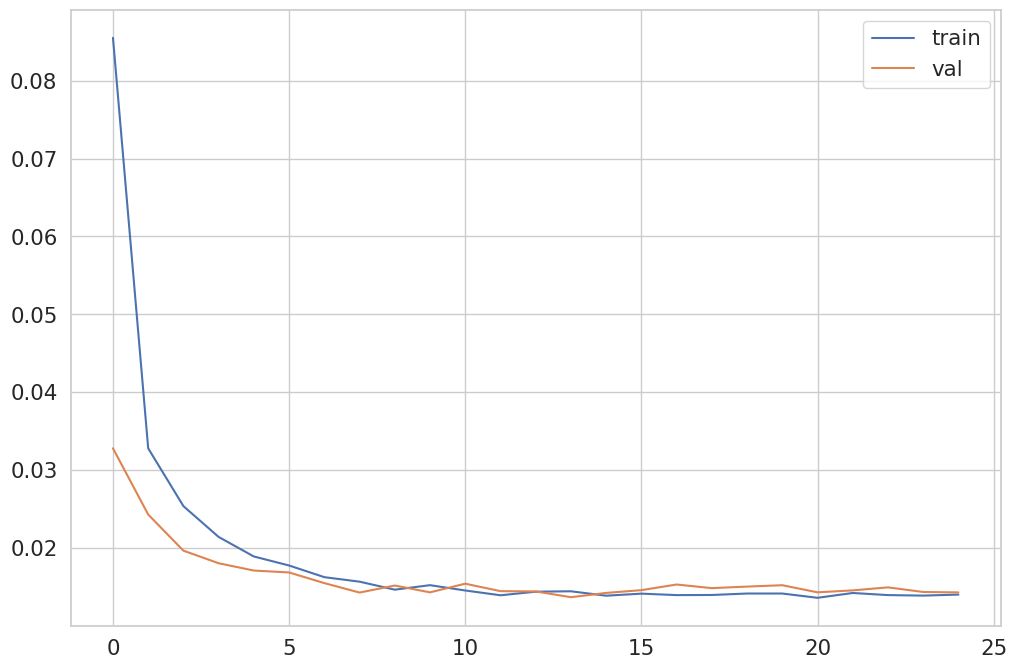

In [15]:
sns.set(style="whitegrid", font_scale=1.4)
# Построим график потерь при обучении и валидации
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [16]:
# Получение предсказаний из функции предсказания
predictions = [class_names[x] for x in predict(model).numpy().astype(int)]

In [17]:
# Получение названий тестовых картинок
test_filenames = [filename[0].split('/')[-1] for filename in test_dataset.imgs]

In [22]:
import csv   
fields=["Id","Expected"]
with open(r'submission_test.csv', "w") as f:
    writer = csv.writer(f)
    writer.writerow(fields)
    for answer in zip(test_filenames, predictions):
        writer.writerow(answer)